In [1]:
!pip install sentencepiece

import pandas as pd
import seaborn as sns
import fastai
from fastai.text import *
from fastai.text.transform import Vocab

sns.set()

     |████████████████████████████████| 1.2 MB 4.3 MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
print("torch version:", torch.__version__)
print("fastai version:", fastai.__version__)

torch version: 1.10.0+cu111
fastai version: 1.0.61


In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
path = Path('drive/My Drive/Colab Notebooks/SentimentAnalysis/data')
model_path = Path('drive/My Drive/Colab Notebooks/SentimentAnalysis/model/pretrain')
path.ls()

[PosixPath('drive/My Drive/Colab Notebooks/SentimentAnalysis/data/test.csv'),
 PosixPath('drive/My Drive/Colab Notebooks/SentimentAnalysis/data/train.csv'),
 PosixPath('drive/My Drive/Colab Notebooks/SentimentAnalysis/data/unlabeled.csv')]

# Data Preparation

In [6]:
df = pd.read_csv(path/'unlabeled.csv', encoding="utf-8")
df.head()

,text,rating
0,初日に映画観てきました…リハーサルとは思えないほどに歌もダンスもクオリティが高くて本当に素晴...,5.0
1,デビュー当時からのファンで、毎回心待ちにしてアルバムを買うのですが、先回に続き今回も”ん〜”...,2.0
2,少数派かもしれないがわたしの評価は低い。 聞いてみて大人しいなあーと思った。 アルバムの前...,2.0
3,「雫」を聴いて気になり、「虹のレシピ」で決意を感じ、「ゴールデンタイムラバー」で勝ちを確信。...,5.0
4,DISC1はオリジナルアルバムマスター音源、\n DISC2は未発表デモ音源及びマイケルによ...,5.0


In [7]:
df['length'] = df['text'].str.len()
stats = df[['rating', 'length']].groupby('rating').describe()
stats.head()

length                                                          
          count        mean         std  min    25%    50%    75%     max
rating                                                                   
1.0     14170.0  184.940720  153.166567  2.0   87.0  143.0  235.0  3245.0
2.0     13776.0  227.044861  175.752541  2.0  110.0  180.0  292.0  3330.0
4.0      6881.0  251.009010  188.309585  4.0  123.0  195.0  328.0  3652.0
5.0     21065.0  245.291526  192.430521  1.0  117.0  186.0  317.0  3342.0

In [8]:
positive = df[(df['rating'] > 3) & (df['length'] > 10)].copy()
positive['rating'] = 'positive'
pos = positive.sample(20000)
len(pos)

20000

In [9]:
negative = df[(df['rating'] < 3) & (df['length'] > 10)].copy()
negative['rating'] = 'negative'
neg = negative.sample(20000)
len(neg)

20000

In [10]:
sample = pd.concat([pos, neg])
sample = sample[['text', 'rating']]
sample.head()

,text,rating
10457,ようやく、Yoshikiの作品が新しく出ました。 と言っても、過去のＸやプロデュースした曲や...,positive
6768,初のコンセプトアルバムだったとか、ジャケットのデザインが各方面に影響を与えた（例えばThe ...,positive
42018,鋼の錬金術師のエンディングテーマ。 だったと思います。 CMで見て、聞いてピーンときました！...,positive
11951,なぜいつも全曲じゃないんですかね？自分は１曲丸々イースターの曲が欲しかったです。サントラ３枚...,positive
17774,ZIGGYを改めSNAKE HIP SHAKESになっていた時代のセカンドアルバム。 とにか...,positive


In [11]:
sample.to_csv(path/'amazon-reviews.csv', index=False)

# Language and Classification Models Training

In [12]:
class SentencepieceTokenizer(BaseTokenizer):
    def __init__(self, lang: str='ja'):
        try:
            import sentencepiece as spm  
        except ImportError:
            raise Exception('sentencepiece module is missing: run `pip install sentencepiece`')
        self.tok = spm.SentencePieceProcessor()
        self.tok.Load(str(model_path/'spm.model'))
    
    def tokenizer(self, t:str) -> List[str]:
        return self.tok.EncodeAsPieces(t)

In [13]:
sent = SentencepieceTokenizer()
sent.tokenizer('ムービークリニックにようこそ。')

['▁', 'ムービー', 'クリ', 'ニック', 'に', 'よう', 'こそ', '。']

In [14]:
import pickle
itos = pickle.load(open(model_path/'itos_wt-all.pkl', 'rb') )
vocab = Vocab(itos)
tok = Tokenizer(tok_func=SentencepieceTokenizer)

In [15]:
# Language model data
data_lm = TextLMDataBunch.from_csv(path, 'amazon-reviews.csv', tokenizer=tok, vocab=vocab, text_cols='text', label_cols="rating")

In [16]:
# Classifier model data
data_clas = TextClasDataBunch.from_csv(path, 'amazon-reviews.csv', tokenizer=tok, vocab=data_lm.train_ds.vocab, text_cols='text', label_cols="rating", bs=48)

In [17]:
data_lm.show_batch()

idx,text
0,し ます 。 ▁ な んだ か もう ちょっと 何とか な らなかった の で しょう か 。 。 。 ▁ ファン な だけ に 残 念 です 。 ▁ 次 は 期待 したい です 。 ▁ xxbos ▁ 雑誌 『 se ven te en 』 の 現役 モデル という 肩 書き から 、 アイドル 路線 ば く 進 の 曲 構成 を 想像 する 方 が多い だろう 。 しかし 、
1,」 を 大 胆 に 用 い ています ! ▁ 当時 、 かなり 話題 になり ました ! ▁ レス ・ ポール で の ギター リ フ 、 ブルー ジー な ソロ 、 ▁ア コース ティック で の 幻想 的な アル ペ ジオ ▁ など など 。 。 。 「 伝 家の 宝 刀 、 <unk> 裂 !」 です 。 <unk> ▁d av id <unk> ▁c over da le の 歌唱
2,ジョン & ヨー コ の問題 作 だから 買 う んだ よ な ・ ・ ・ 怖 い もの 見た さ ? 聴 きた さ ? ▁ これも 一種の ジャ ケ 買い かな ? ▁ アナログ 盤 も 持っている が 、 ジョージ の 「 電子 音楽 の世界 」 とは 違い ” さわ り ” すら 聴 いた こと なかった 。 <unk> <unk> になって 初めて 聴 いたが これも 良い か 悪い か
3,<unk> <unk> の中で 最低 クラス の 出来 。 ▁ 録音 レベル を 押さえ すぎ ているため 、 全体 に 音 が 遠 い 。 ▁ グラ モ フォン の <unk> sa <unk> <unk> 録音 は 気 に入 っている 物 が多い だけ に ▁ 大変 残 念 。 せ っか く の ム ター の 演奏 が 台 無 し 。 ▁ xxbos ▁ モー ツ アルト の 曲 と言う こともある か
4,センス 」 と <unk> み 合 って も 、 この曲 自体が 浅 い から ね 。 そこ の 点 から ▁ やはり 「 <unk> き 」 が 回 ってくる と思う 。 レビュー 書く って 事 は 僕 も この曲 は 一 応 意識 して る んで しょう けど ね 。 この チャ ラ チャ ラ 活動 して ▁ ただ イ ライ ラ する 歌詞 を 書いて は 唄 う ...


In [18]:
data_lm.save('data_lm_export.pkl')
data_clas.save('data_clas_export.pkl')

## Language Model

In [19]:
data_lm = load_data(path, 'data_lm_export.pkl')

In [20]:
learn = language_model_learner(data_lm, AWD_LSTM, pretrained=False, drop_mult=0.5)
learn.load_pretrained(wgts_fname=model_path/'qrnn_wt-100.pth', itos_fname=model_path/'itos_wt-100.pkl', strict=False)

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (31999 items)
x: LMTextList
▁ xxbos ▁ ただ プロデューサー が 豪華 な だけ ・ ・ ▁ ただ それ だけ ・ ・ ▁ 聞く 価値 はない です 。,▁ xxbos ▁ 上 地 さん 結 構 好き で 、 前回 の ひ ま わり が そこ そこ いい 歌 だった だけ に ▁ 今回 の 曲を 聴 いて <unk> 然と しま した 。 ▁ 一度 曲を 全部 聴 いて から の 購入 を お 勧め し ます 。 ▁ な んだ か もう ちょっと 何とか な らなかった の で しょう か 。 。 。 ▁ ファン な だけ に 残 念 です 。 ▁ 次 は 期待 したい です 。,▁ xxbos ▁ 雑誌 『 se ven te en 』 の 現役 モデル という 肩 書き から 、 アイドル 路線 ば く 進 の 曲 構成 を 想像 する 方 が多い だろう 。 しかし 、 彼女は そんな 小さい 枠 には 収 ま らない ない 。 聞いて いた だけ れば 分かる と思う が 、 自身が 書いた 詩 や 曲 の 完成 度 から み て 、 そこ ら 辺 の アイドル と一緒に するのは い か が なもの だろう 。,▁ xxbos ▁ <unk> ki <unk> <unk> <unk> ing <unk> <unk> <unk> ok e ! なん て カッ コイ イ 名前 だろう ! 当時 ロー ティーン だった 僕 は 真っ 先に レコード 屋 へ 走 った よ 。 急 いで 家に 帰り レコード に 針 を 落とし た 瞬間 スピーカー から 聞こえ てきた re qu ie m そして w ar ▁d ance 。 震 え ました 。 当時 y ou th が s id ▁ vi ci ous 似 なん て 話題 になっていた 事 もあった っ け 。 今 じゃ リ ミ キ サー として 名を 上げた けど 、 初期の k ill ing ▁ lo ke , re m ix して く れない かな ー 、 そ した ら オ モ シ ロイ の に 。 でも 、 この アルバム は ス ゴ イ ! よ 、 マ

In [21]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,4.299634,4.174416,0.296153,08:26


In [22]:
learn.unfreeze()
learn.fit_one_cycle(10, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,4.122401,4.134737,0.301001,08:27
1,4.051182,4.059516,0.308920,08:27
2,3.969052,3.981359,0.317167,08:28
3,3.892157,3.918641,0.325025,08:27
4,3.757444,3.872549,0.331250,08:24
5,3.680303,3.840145,0.336603,08:24
6,3.618864,3.817923,0.340209,08:27
7,3.564881,3.806134,0.342428,08:26
8,3.502849,3.804280,0.343469,08:28
9,3.470438,3.805534,0.343552,08:28


In [23]:
learn.save_encoder('ja_finetuned_enc')

In [24]:
learn.predict("この映画はなかなか", n_words=20)

'この映画はなかなか の 価値 は ずっと あり ます 。 ▁ でも 、 私 名詞 としては この アルバム に関して 幼い ために も 聞き'

## Classifier Model

In [25]:
classifier = text_classifier_learner(data_clas, AWD_LSTM, pretrained=False, drop_mult=0.5)
classifier.load_pretrained(wgts_fname=model_path/'qrnn_wt-100.pth', itos_fname=model_path/'itos_wt-100.pkl', strict=False) 
classifier.load_encoder('ja_finetuned_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (31999 items)
x: TextList
▁ xxbos ▁ 軽 快 な ロック ン ロール ナンバー の 「 <unk> al rea dy <unk> ▁g one 」、「 j ame s ▁de an 」 が <unk> <unk> で いう と a 面 、 b 面 の 冒頭 を 飾り 、 その あと に バ ラード 、 カントリー フ レー バー <unk> う 曲 へと 続いて いく 。 ペ ダル スティー ル ギター の 柔らか な 音 が 心 に 響 く 「 <unk> my <unk> 」、「 o l ' 55 」 は 地 味 ながら 良 質 な カントリー ロックバンド として の 側面 を 良く 表 している 。 ▁ 一方で 新 加入 の d on <unk> ▁f el der によって ギター の 音 が 分 厚 く なっている 。 ス ライ ド ギター が 印象 的な 「 g ood <unk> ▁d ay ▁in <unk> ▁h ell 」 が 典 型 。 ▁ タイトル ナンバー の 「 o n ▁the <unk> ▁b or der 」 は ファン ク 、 ソウル 色の 濃 い ナンバー 。 ラスト ナンバー は 大ヒット ( 全米 1 位 ) した 「 <unk> the <unk> ▁b est <unk> <unk> f ▁ <unk> my <unk> ▁l ove 」 。 ウエスト コース ト ロック の サウンド に ソウル バ ラード の 味 付け を施し た この曲 で イーグル スは ビッグ ネーム の 仲間 入り を果たした 。,▁ xxbos ▁「 そば にいる ね 」 で ヒット したとき 何 で この曲 が って 思 った !? ▁ そんな に いい 曲 か <unk> 。 ▁ それに デビュー 2 年目 で ベスト 早 すぎ 〜 ▁ もう この 人 人気 落ち た ね 〜 ▁ は や い 〜,▁ xxbos <unk> ▁b <unk> est は 一人 一人 の中 にある もので す 。 シングル 、 オリジナル アルバム から の 数 ある 選 曲 に こ だ わり すぎ て 、 この 

In [26]:
classifier.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.435718,0.359952,0.842895,03:53


In [27]:
classifier.freeze_to(-2)
classifier.fit_one_cycle(4, slice(5e-3/2., 5e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.371101,0.296243,0.881640,05:08
1,0.282067,0.250212,0.901637,05:29
2,0.231914,0.228635,0.911386,05:09
3,0.190957,0.235281,0.912886,04:26


In [28]:
classifier.save('ja_class')

In [29]:
classifier.export('export.pkl')

In [30]:
classifier.load('ja_class');

In [31]:
interp = ClassificationInterpretation.from_learner(classifier)

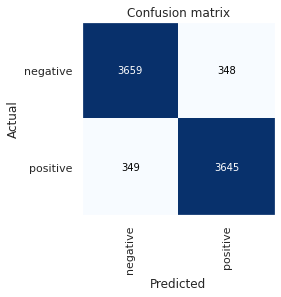

In [32]:
interp.plot_confusion_matrix()

In [33]:
classifier.predict("すごく面白い映画です。")

(Category tensor(1), tensor(1), tensor([0.0033, 0.9967]))

In [34]:
classifier.predict("この映画が好きではありません。")

(Category tensor(0), tensor(0), tensor([0.8102, 0.1898]))

In [35]:
txt_ci = TextClassificationInterpretation.from_learner(classifier)
txt_ci.show_top_losses(10)

Text,Prediction,Actual,Loss,Probability
▁ xxbos ▁< b ' z を あまり よく 知 らなかった 人 へ > ▁ 果 た して 、 この <unk> <unk> に 収録されている 曲が バ ラード かどうか は わか り ません が 、 どれ も 最高 傑作 の楽曲 ばかり 。 <unk> ▁b ' z でも こんな じ ー ー ー ん と くる 名 曲が たくさん ある んです 。 ▁ 独特の 世界観 を も った 歌詞 や ギター の,positive,negative,9.33,0.00
▁ xxbos ▁ ver 6 . 0 ツアー の 最中 に 、 発売 される アルバム 。 ▁ どんな 曲 が入る のか 、 今 から とても 楽しみ に し ています 。 ▁ 個人 的には 、 <unk> <unk> で 盛り 上 が れる 曲が 入 れば いい な と思って おり ます 。 ▁ 初回 版 には 、 <unk> <unk> も 付く そう なので 、 お 買い 得 です ね 。 ▁ <unk>,positive,negative,8.50,0.00
▁ xxbos ▁「 レイ ヴ ・ me et s ・ メタル 」 なん て キャッチ ・ コピー を見た 瞬間 、 ゴ ミ だろう と思った が 、 意 外 に 悪 くない 。 リズム ・ セ クション が デジタル ・ ビート でない 事 が大きい ね 。 確か に ディス コ 、 ダンス 調 の 装飾 音 が 加えられ ているが 、 ロック の 要素 の方が 断 然 強い 。 ▁ 若 さ,negative,positive,7.85,0.00
▁ xxbos ▁ まず ヨーロッパ で 成功 し 、 本国 アメリカでは 「 ノー ・ ファン 時代 」 まで ▁ 過ごし た バック ストリート ・ ボーイズ 。 ▁ それが じ わ じ わ と アメリカ でも 売れ 始め 、 ノ リ 始めた ときに 出した の が この ▁「 ミ レ ニア ム 」 。 当時 では 発売 第一 週 の セールス が 史上 最高 となり 、 また ▁ 日本で 人気 が出た,positive,negative,7.50,0.00
▁ xxbos ▁ 後半 に 少 々 マン ネ リ が見られる が 、 久 々 に アルバム を通して 聴 ける アルバム だ と思う 。,positive,negative,7.43,0.00
▁ xxbos ▁ せ っか く リミックス アルバム を出す なら 、 もっと 初期の 曲 ( ハイ カラ ガール 〜 s . f . ▁s ound ▁f ur n it ure ) を や った ほう が 面 白 かった ん じゃない かな <unk> 、 と 。 ▁ ベスト アルバム として 買 う の は お 勧め でき ません が 、 ▁ 過去の アルバム を聞いた こと のある 人 には 十分 楽しめる,negative,positive,7.41,0.00
▁ xxbos ▁ <unk> 雑誌 の レビュー を 読 んで 購入した が 大 方 期待 通り であった 。 ヘ ヴィ な リズム 隊 と ギター の キ レ ある バ ッキング は 素晴らしい の だが 肝 心 な ボーカル が ... 。 声 量 がなく バンド の よ さ を 半 減 させている 。 歌 は 上 手 い だけ にも った いない 気 が した 。 よく を 言えば,negative,positive,7.37,0.00
"▁ xxbos ▁ ・ ・ と思って いたが 聴 き こ む と なかなか いい 感じ 。 ▁ プライ ド オブ プレイ ス 、 s ec re t <unk> de , ピエ ロ 、 傷 だ ら け でも 抱 き し めて 、 <unk> ▁b el ie ve ▁in ▁you が 特に お 勧め 。 ▁ 外見 だけ だろう なん て 思 って る 方 も ぜ ひ 挑戦 して",positive,negative,6.59,0.00
▁ xxbos ▁ 録音 が 古い の と 、 いま いち 爆発 力 に 乏 しい 点で 4 ポイント 。 ▁ 寄せ 集め 楽 団 の 弱 さ が 出て ます 。,negative,positive,6.44,0.00
▁ xxbos ▁ この曲 は大 好き です 。 ▁ <unk> され ました 。 ▁「 何 ひとつ う し な わず 」 も 良 かった です 。 ▁ 自分が 気 に入った の はその 二 曲 だけで す 。,positive,negative,6.40,0.00
